# JAX estimator simple BC model
In this notebook we program an estimator for epsilon parameter in BC model with JAX procedure. 

Until now, we have seen the same estimation (maximization of the likelihood function obtained from the ABM) with Torch and scipy.

For this reason, we need to define also the JAX simulator for the BC model, that returns `jnp` objects for edgelist and opinion trajectories.

These functions will be stored in the src file `jax_optimization_BC.py`.

In [54]:
import jax
from jax import jit
import numpy as np
import jax.numpy as jnp
import sys
sys.path += ['../src/']
import simulator_BC as sim_bc
import estimation_epsilon_BC as est_bc
from scipy.special import expit as sigmoid
from scipy.special import expit as logit
import matplotlib.pyplot as plt
import optax
from time import time

## JAX Simulator
At first, define the functions we need in JAX, that are the sigmoid, the logit and the binary cross-entropy with logit (BCE(sigmoid(x))

In [2]:
def jnp_sigmoid(x):
    return 1 / (1 + jnp.exp(-x))

def jnp_logit(x):
    return jnp.log(x) - jnp.log(1 - x)

def jnp_bce_with_logits(x,y):
    xs = jnp_sigmoid(x)
    loss = -jnp.sum(y * jnp.log(xs) + (1-y) * jnp.log(1 - xs))
    return loss

Simulate a bounded confidence model, with input
- `N` number of agents
- `T`number of timesteps
- `edge_per_t`the number of edges at each timestep
- `epsilon` the bounded confidence parameter. The probability of interactions between two nodes with opinions x_u and x_v is $\sigma(\rho(\epsilon - |x_u - x_v))$ (since we are studying the stochastic bounded confidence model).
- `mu`the convergence parameter. It drives the update of the opinions in case of positive interaction. If `s = 1` x_u += mu * (x_v - x_u), where s = 1 if the interaction occurred
- `rho`represents the stochasticity of the model.

The function returns two `np`arrays, that will be converted in `jnp`arrays: `edges`and `X`, the list of edges as `u,v,s,t` and the array of the opinions, where `X[t,:]` is the vector of all the opinions at time `t`.

In [3]:
def simulator_stoch_np(N, T, edge_per_t, epsilon, mu, rho = 10, seed = None, x0 = []):
    if seed != None:
        np.random.seed(seed)
    if len(x0) == 0:
        x0 = np.random.uniform(size = [1,N])
    
    edges = []#np.zeros([T * edge_per_t, 4])
    t = 0
    x0 = np.random.uniform(size = [1,N])
    
    X = np.repeat(x0, T, axis = 0)
    
    for t in range(T-1):
        X[t+1] = X[t]
        interacting_nodes = []
        for new_edge in range(edge_per_t):
            while True:
                u = np.random.randint(N) #pick a user
                if u not in interacting_nodes:
                    interacting_nodes.append(u)
                break
            while True:
                v = np.random.randint(N)
                if v not in interacting_nodes:
                    interacting_nodes.append(v)
                break
            
            
            dist = jnp.abs(X[t,u] - X[t,v])
            
            if np.random.random() < sigmoid(rho * (epsilon - dist)):
                X[t+1, v] += mu * (X[t,u] - X[t,v])
                X[t+1, u] += mu * (X[t,v] - X[t,u])
                edges.append(np.array([u,v,1,t]))
                #edges[t + new_edge] = np.array([u,v,1,t])
            else:
                edges.append(np.array([u,v,0,t]))
                #edges[t + new_edge] = np.array([u,v,0,t])
    return X, np.array(edges)

In [95]:
mu, epsilon, epsilon0 = 0.2, 0.2, 0.1
rho = 70

N = 100
T, edge_per_t = 50, 5

X, edges = sim_bc.simulator_stoch(N, T, edge_per_t, epsilon, mu, rho)

In [96]:
X, edges = simulator_stoch_np(N, T, edge_per_t, epsilon, mu, rho)
u,v,s,t = edges.T

In [97]:
X_jnp, edges_jnp = jnp.array(X), jnp.array(edges)

In [98]:
diff_X_jnp = jnp.abs(X_jnp[t,u] - X_jnp[t,v])

### Likelihood function
This is the likelihood of observing the given list of signed edges with a given set of parameters and the vector of opinion differences between `t+1` and `t`.

In [64]:
@jit
def tot_neg_log_likelihood_jnp(edges_jnp, rho, epsilon, T, diff_X_jnp):
    u,v,s,t = edges_jnp.T
    kappa = jnp_sigmoid(rho * (epsilon - jnp.abs(diff_X_jnp))) #probability of observing an edge, as the sigmoid of the absolute value of the difference of opinions

    return jnp_bce_with_logits(kappa, s) #return the BCE of probability of observing edges and s (sign of the edges)


In [41]:
loss_closure = lambda x: tot_neg_log_likelihood_jnp(edges_jnp, rho, x, T, diff_X_jnp)

In [42]:
x = np.arange(0,1,0.01)
y = [loss_closure(u) for u in x]

Compare the likelihood of observing the edges and X varying epsilon.

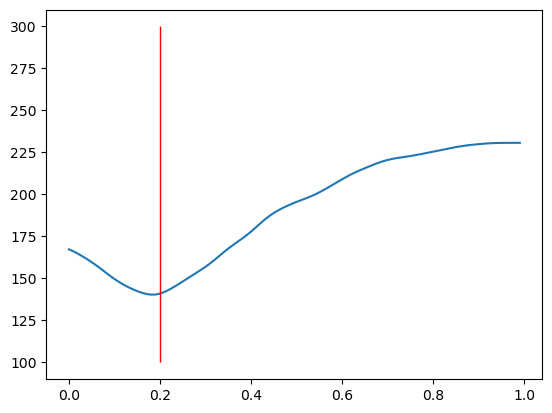

In [43]:
plt.plot(x,y)
plt.vlines(x = epsilon, ymin = 100, ymax = 300, colors = "red", lw = 1)

### Optimization of the likelihood
Let us optimize the likelihood finding the best `epsilon` with `jax`optimization.

We compare the optimization with and withou `@jit`.

In [66]:
history = {"epsilon": [], "loss": []}
num_epochs = 100

t0 = time()
optimizer = optax.adam(learning_rate = 0.0001)

theta0 = jnp_sigmoid(0.05)

params = {"theta": jnp.array([theta0])}
opt_state = optimizer.init(params)

history = {"epsilon": [], "loss": []}


compute_loss = lambda params: tot_neg_log_likelihood_jnp(edges_jnp, rho, jnp_logit(params["theta"]), T, diff_X_jnp)

@jit
def jit_compute_loss(params):
    return tot_neg_log_likelihood_jnp(edges_jnp, rho, jnp_logit(params["theta"]), T, diff_X_jnp)


for epoch in range(num_epochs):
    history["epsilon"].append(jnp_logit(params["theta"]))
    history["loss"].append(compute_loss(params))
    grads = jax.grad(jit_compute_loss)(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
t1 = time()

print("Time", t1 - t0)
print(history["epsilon"][-1])

Time 0.399442195892334
[0.09084243]


In [65]:
history = {"epsilon": [], "loss": []}
num_epochs = 100

t0 = time()
optimizer = optax.adam(learning_rate = 0.0001)

theta0 = jnp_sigmoid(0.05)

params = {"theta": jnp.array([theta0])}
opt_state = optimizer.init(params)

history = {"epsilon": [], "loss": []}

compute_loss = lambda params: tot_neg_log_likelihood_jnp(edges_jnp, rho, jnp_logit(params["theta"]), T, diff_X_jnp)

for epoch in range(num_epochs):
    history["epsilon"].append(jnp_logit(params["theta"]))
    history["loss"].append(compute_loss(params))
    grads = jax.grad(compute_loss)(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
t1 = time()

print("Time", t1 - t0)
print(history["epsilon"][-1])

Time 0.7634611129760742
[0.09084243]


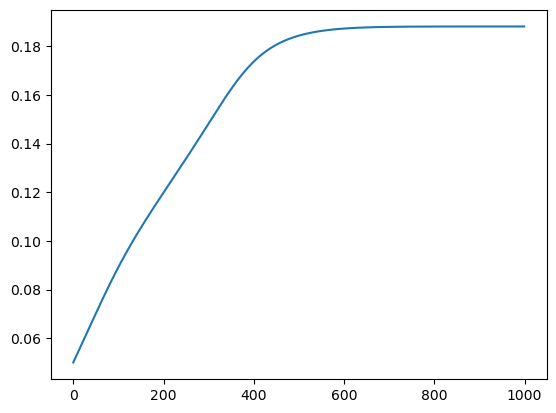

In [22]:
plt.plot(history["epsilon"])

In [92]:
class EarlyStopping:
    def __init__(self, patience = 5, min_delta = 0, min_epochs = 100):

        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False
        self.min_epochs = min_epochs

    def __call__(self, previous_epsilon, current_epsilon, epoch):
        if self.min_delta > 0:
            if (epoch > self.min_epochs) & (np.abs(previous_epsilon - current_epsilon) < self.min_delta):
                self.counter +=1
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.counter = 0



def estimator_BC_jax(rho, mu, X, edges, epsilon0, patience = 20, min_delta = 10e-6, min_epochs = 100,
                     num_epochs = 1000, lr = 0.0001):
    history = {"epsilon": [], "loss": [], "grad": []}
    
    optimizer = optax.adam(learning_rate = lr)
    
    early_stopping = EarlyStopping(patience, min_delta, min_epochs)
    
    theta0 = jnp_sigmoid(epsilon0)
    
    params = {"theta": jnp.array([theta0])}
    opt_state = optimizer.init(params)
    
    u,v,s,t = edges.T
    diff_X = jnp.abs(X[t,u] - X[t,v])
    
    @jit
    def jit_compute_loss(params):
        return tot_neg_log_likelihood_jnp(edges_jnp, rho, jnp_logit(params["theta"]), T, diff_X_jnp)

    
    for epoch in range(num_epochs):
        grads = jax.grad(jit_compute_loss)(params)
        history["epsilon"].append(jnp_logit(params["theta"]))
        history["loss"].append(jit_compute_loss(params))
        history["grad"].append(grads["theta"])
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        
        
        if epoch > min_epochs:
            early_stopping(history["epsilon"][-1], history["epsilon"][-2], epoch)
            if early_stopping.early_stop:
                break
    return history

In [95]:
mu, epsilon, epsilon0 = 0.2, 0.2, 0.1
rho = 70

N = 100
T, edge_per_t = 50, 5

X, edges = sim_bc.simulator_stoch(N, T, edge_per_t, epsilon, mu, rho)

In [96]:
X, edges = simulator_stoch_np(N, T, edge_per_t, epsilon, mu, rho)
u,v,s,t = edges.T

In [97]:
X_jnp, edges_jnp = jnp.array(X), jnp.array(edges)

In [98]:
diff_X_jnp = jnp.abs(X_jnp[t,u] - X_jnp[t,v])

In [123]:
history_jax = estimator_BC_jax(rho, mu, X_jnp, edges_jnp, epsilon0, min_delta = 10e-7, num_epochs = 1000, lr = 0.0001)

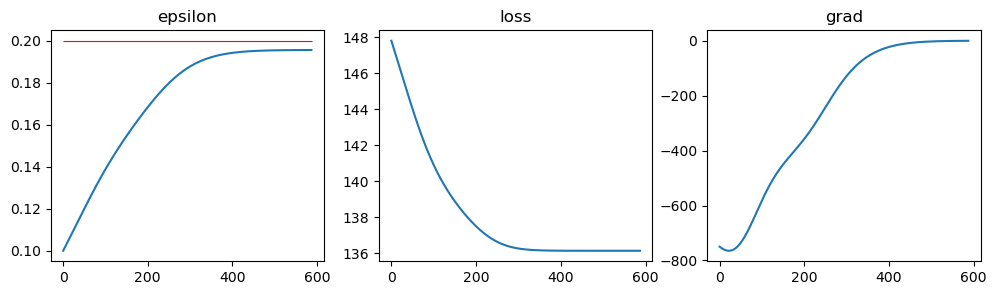

In [124]:
est_bc.print_history(history_jax, epsilon)